In [29]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A

# Rutas al dataset y archivos
DICOM_ROOT = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_with_other'
CSV_PATH = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/others_with_image_names.csv'
OUTPUT_ROOT = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8'

# Crear carpetas principales (training y test)
TRAIN_FOLDER = os.path.join(OUTPUT_ROOT, 'training')
TEST_FOLDER = os.path.join(OUTPUT_ROOT, 'test')

os.makedirs(TRAIN_FOLDER, exist_ok=True)
os.makedirs(TEST_FOLDER, exist_ok=True)

# Crear carpetas de categorías y subcategorías
CATEGORIES = ['masas', 'calcificaciones', 'otros']
BIRADS_CATEGORIES = ['benigno', 'maligno', 'sospechoso']

for split_folder in [TRAIN_FOLDER, TEST_FOLDER]:
    for category in CATEGORIES:
        for birads in BIRADS_CATEGORIES:
            os.makedirs(os.path.join(split_folder, category, birads), exist_ok=True)

# Tamaño objetivo para el recorte
TARGET_SIZE = (299, 299)

# Leer las anotaciones CSV
ss1 = pd.read_csv(CSV_PATH)

# Limpiar las categorías eliminando los caracteres adicionales
ss1['finding_categories'] = ss1['finding_categories'].str.strip("[]'")

# Crear un DataFrame vacío para guardar las nuevas coordenadas
ss1_rescaled = pd.DataFrame(columns=ss1.columns)

# Lista de subcategorías para la categoría 'otros'
OTROS_CATEGORIES = [
    'Focal Asymmetry',
    'Architectural Distortion',
    'Asymmetry',
    'Suspicious Lymph Node',
    'Skin Thickening',
    'Global Asymmetry',
    'Nipple Retraction',
    'Skin Retraction'
]

# Definir secuencia de aumentación usando albumentations con soporte para bounding boxes
AUGMENTATION_SEQ = A.Compose([
    A.Rotate(limit=20, p=0.5),  # Rotación aleatoria entre -20 y 20 grados
    A.HorizontalFlip(p=0.5),     # Flip horizontal
    A.VerticalFlip(p=0.2),       # Flip vertical
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),  # Traslación y escalado
    A.RandomBrightnessContrast(p=0.3),  # Cambios de brillo y contraste
    A.GaussianBlur(blur_limit=(3, 5), p=0.2)  # Desenfoque Gaussiano
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category']))

def get_dicom_path(image_id):
    """
    Obtener la ruta del archivo DICOM usando image_id.
    """
    for study_id in os.listdir(DICOM_ROOT):
        study_path = os.path.join(DICOM_ROOT, study_id)
        if os.path.isdir(study_path):
            for ext in ['.dicom', '.dcm', '']:
                dicom_filename = image_id + ext
                dicom_path = os.path.join(study_path, dicom_filename)
                if os.path.exists(dicom_path):
                    return dicom_path
    raise FileNotFoundError(f"No se encontró el archivo DICOM para image_id: {image_id}")

def map_birads_to_category(birads):
    """
    Mapear BIRADS a categorías 'benigno', 'maligno', 'sospechoso'.
    """
    if birads in ['BI-RADS 0', 'BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3']:
        return 'benigno'
    elif birads == 'BI-RADS 4':
        return 'sospechoso'
    elif birads in ['BI-RADS 5', 'BI-RADS 6']:
        return 'maligno'
    else:
        print(f"Advertencia: BIRADS desconocido '{birads}'. Asignando a 'benigno'.")
        return 'benigno'

def extract_roi(image_name, split, birads, finding_categories):
    """
    Extraer la ROI de una imagen DICOM, recortarla, redimensionarla y guardarla.
    """
    global ss1_rescaled

    image_id = image_name.split('_')[0]
    dicom_path = get_dicom_path(image_id)

    # Leer la imagen DICOM
    dicom = pydicom.dcmread(dicom_path)
    original_image = dicom.pixel_array

    # Aplicar VOI LUT con prefer_lut=True
    img_windowed = apply_voi_lut(original_image, dicom, prefer_lut=True)

    # Manejar Photometric Interpretation
    photometric_interpretation = dicom.get('PhotometricInterpretation', 'UNKNOWN')
    if photometric_interpretation == 'MONOCHROME1':
        img_windowed = img_windowed.max() - img_windowed
        print(f"Imagen {image_name} invertida debido a Photometric Interpretation: {photometric_interpretation}")
    else:
        print(f"Imagen {image_name} Photometric Interpretation: {photometric_interpretation}")

    # Normalizar la imagen a [0, 255]
    img_windowed = ((img_windowed - img_windowed.min()) / 
                    (img_windowed.max() - img_windowed.min()) * 255).astype(np.uint8)

    # Extraer coordenadas de la ROI
    try:
        coords = ss1.loc[ss1['image_name'] == image_name, ['xmin', 'ymin', 'xmax', 'ymax']].iloc[0]
        x1, y1, x2, y2 = coords['xmin'], coords['ymin'], coords['xmax'], coords['ymax']
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return

    # Validar coordenadas
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)

    width, height = x2 - x1, y2 - y1

    # Agregar padding del 10% al lado mayor y hacer cuadrado
    if width > height:
        padding_x = int(width * 0.1)
        padding_y = (width - height) // 2
        new_size = width + padding_x
    else:
        padding_y = int(height * 0.1)
        padding_x = (height - width) // 2
        new_size = height + padding_y

    # Calcular nuevos límites y asegurarse de que sean enteros
    x1_new = int(max(x1 - padding_x, 0))
    y1_new = int(max(y1 - padding_y, 0))
    x2_new = int(min(x1_new + new_size, img_windowed.shape[1]))
    y2_new = int(min(y1_new + new_size, img_windowed.shape[0]))

    # Recortar la imagen
    crop = img_windowed[y1_new:y2_new, x1_new:x2_new]

    if crop.size == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío.")
        return

    # Redimensionar
    crop_resized = cv2.resize(crop, TARGET_SIZE)

    # Calcular nuevas coordenadas
    scale_x = TARGET_SIZE[0] / crop.shape[1]
    scale_y = TARGET_SIZE[1] / crop.shape[0]

    xmin_rescaled = int((x1 - x1_new) * scale_x)
    ymin_rescaled = int((y1 - y1_new) * scale_y)
    xmax_rescaled = int((x2 - x1_new) * scale_x)
    ymax_rescaled = int((y2 - y1_new) * scale_y)

    # Determinar directorio base
    if split.lower() in ['train', 'training']:
        base_dir = TRAIN_FOLDER
    elif split.lower() == 'test':
        base_dir = TEST_FOLDER
    else:
        print(f"Error: Split desconocido '{split}' para la imagen {image_name}.")
        return

    # Determinar categoría
    if finding_categories == 'Mass':
        category = 'masas'
    elif finding_categories == 'Suspicious Calcification':
        category = 'calcificaciones'
    elif finding_categories in OTROS_CATEGORIES:
        category = 'otros'
    else:
        print(f"Error: Categoría desconocida '{finding_categories}' para la imagen {image_name}.")
        return

    # Mapear BIRADS a subcategoría
    birads_category = map_birads_to_category(birads)
    output_dir = os.path.join(base_dir, category, birads_category)
    os.makedirs(output_dir, exist_ok=True)

    # Guardar la imagen recortada
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    cv2.imwrite(output_path, crop_resized)
    print(f"Imagen ROI guardada en: {output_path}")

    # Añadir fila al CSV
    new_row = ss1.loc[ss1['image_name'] == image_name].copy()
    new_row['xmin'] = xmin_rescaled
    new_row['ymin'] = ymin_rescaled
    new_row['xmax'] = xmax_rescaled
    new_row['ymax'] = ymax_rescaled
    ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)

def balance_classes_with_augmentation(output_root, target_counts, augmentation_seq):
    """
    Aplica data augmentation para balancear las clases en el conjunto de training.
    
    Parámetros:
    - output_root (str): Ruta al directorio ROICROP8.
    - target_counts (dict): Diccionario con los conteos objetivos por categoría y subcategoría.
    - augmentation_seq (albumentations.Compose): Secuencia de aumentaciones a aplicar.
    """
    global ss1_rescaled

    for category, subcategories in target_counts.items():
        for subcategory, target_count in subcategories.items():
            train_subcategory_path = os.path.join(output_root, 'training', category, subcategory)
            current_count = len([f for f in os.listdir(train_subcategory_path) if f.lower().endswith('.png')])
            
            if current_count >= target_count:
                print(f"{category.capitalize()} - {subcategory.capitalize()} ya está balanceado con {current_count} imágenes.")
                continue  # No se necesita aumentar esta subcategoría

            needed = target_count - current_count
            print(f"Balanceando {category.capitalize()} - {subcategory.capitalize()}: {current_count} -> {target_count} imágenes (necesitas {needed} aumentos)")

            # Lista de imágenes originales para aumentar (excluyendo imágenes ya aumentadas)
            original_images = [f for f in os.listdir(train_subcategory_path) 
                               if f.lower().endswith('.png') and not f.startswith('aug_')]
            if not original_images:
                print(f"Advertencia: No hay imágenes originales para aumentar en {train_subcategory_path}.")
                continue

            # Índice para las imágenes originales
            idx = 0
            total_originals = len(original_images)

            while needed > 0:
                img_name = original_images[idx % total_originals]
                img_path = os.path.join(train_subcategory_path, img_name)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if image is None:
                    print(f"Error: No se pudo leer la imagen {img_path}.")
                    idx += 1
                    continue

                # Obtener las coordenadas originales de la ROI
                image_id = os.path.splitext(img_name)[0]
                row = ss1_rescaled.loc[ss1_rescaled['image_name'] == image_id]
                if row.empty:
                    print(f"Error: No se encontraron coordenadas en el CSV para la imagen {img_name}.")
                    idx += 1
                    continue

                xmin = row['xmin'].values[0]
                ymin = row['ymin'].values[0]
                xmax = row['xmax'].values[0]
                ymax = row['ymax'].values[0]

                # Definir la bounding box
                bbox = [xmin, ymin, xmax, ymax]
                category_label = subcategory  # Etiqueta para la bounding box

                # Aplicar data augmentation con bounding box
                try:
                    augmented = AUGMENTATION_SEQ(image=image, bboxes=[bbox], category=[category_label])
                except Exception as e:
                    print(f"Error durante la augmentación de la imagen {img_name}: {e}")
                    idx += 1
                    continue

                augmented_image = augmented['image']
                augmented_bboxes = augmented['bboxes']

                if not augmented_bboxes:
                    print(f"Advertencia: La augmentación de la imagen {img_name} no generó bounding boxes válidas.")
                    idx += 1
                    continue

                # Asumir una sola bounding box
                augmented_bbox = augmented_bboxes[0]
                augmented_category = augmented['category'][0]

                # Extraer las coordenadas de la bounding box
                try:
                    aug_xmin, aug_ymin, aug_xmax, aug_ymax = map(int, augmented_bbox)
                except ValueError:
                    print(f"Error: Coordenadas de bounding box no válidas para la imagen aumentada de {img_name}.")
                    idx += 1
                    continue

                # Generar un nombre único para la imagen aumentada
                augmented_filename = f"aug_{image_id}_{needed}.png"
                augmented_path = os.path.join(train_subcategory_path, augmented_filename)

                # Guardar la imagen aumentada
                success = cv2.imwrite(augmented_path, augmented_image)
                if success:
                    print(f"Imagen aumentada guardada en: {augmented_path}")

                    # Crear una nueva fila para el CSV con las coordenadas aumentadas
                    new_row = ss1_rescaled.loc[ss1_rescaled['image_name'] == image_id].copy()
                    new_row['image_name'] = os.path.splitext(augmented_filename)[0]
                    new_row['xmin'] = aug_xmin
                    new_row['ymin'] = aug_ymin
                    new_row['xmax'] = aug_xmax
                    new_row['ymax'] = aug_ymax

                    # Añadir la nueva fila al DataFrame rescaled
                    ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)

                    needed -= 1
                else:
                    print(f"Error: No se pudo guardar la imagen aumentada en {augmented_path}.")
                idx += 1

def process_all_images():
    """
    Procesa todas las imágenes, realiza el recorte y prepara el DataFrame rescaled.
    """
    global ss1_rescaled
    for _, row in ss1.iterrows():
        image_name = row['image_name']
        split = row['split']  # 'train', 'training', o 'test'

        # Obtener 'birads' de 'finding_birads' o 'breast_birads'
        birads = row.get('finding_birads', '')
        if pd.isna(birads) or birads.strip() == '':
            birads = row.get('breast_birads', '')
            if pd.isna(birads) or birads.strip() == '':
                print(f"Advertencia: No se encontró 'finding_birads' ni 'breast_birads' para la imagen {image_name}. Asignando 'BI-RADS 0'.")
                birads = 'BI-RADS 0'

        finding_categories = row['finding_categories']

        # Procesar la imagen
        extract_roi(image_name, split, birads, finding_categories)

    # Guardar el CSV intermedio antes de balancear
    intermediate_csv_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/CROP8_intermediate.csv'
    ss1_rescaled.to_csv(intermediate_csv_path, index=False)
    print(f"CSV intermedio guardado en: {intermediate_csv_path}")

    # Definir los conteos objetivos por categoría y subcategoría basado en el split de training
    # Estos deben ser los máximos existentes por categoría para balancear
    target_counts = {
        'masas': {
            'benigno': 443,
            'maligno': 443,
            'sospechoso': 443
        },
        'calcificaciones': {
            'benigno': 224,  # Máximo en Sospechoso
            'maligno': 224,
            'sospechoso': 224
        },
        'otros': {
            'benigno': 215,
            'maligno': 215,
            'sospechoso': 215
        }
    }

    # Aplicar data augmentation para balancear las clases en el split de training
    balance_classes_with_augmentation(OUTPUT_ROOT, target_counts, AUGMENTATION_SEQ)

    # Guardar el CSV final después de balancear
    final_csv_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/CROP8_AU.csv'
    ss1_rescaled.to_csv(final_csv_path, index=False)
    print(f"CSV final guardado en: {final_csv_path}")

if __name__ == "__main__":
    process_all_images()


Imagen 001ade2a3cb53fd808bd2856a0df5413_0 invertida debido a Photometric Interpretation: MONOCHROME1
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/masas/sospechoso/001ade2a3cb53fd808bd2856a0df5413_0.png
Imagen 001ade2a3cb53fd808bd2856a0df5413_1 invertida debido a Photometric Interpretation: MONOCHROME1
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/calcificaciones/sospechoso/001ade2a3cb53fd808bd2856a0df5413_1.png
Imagen 001ade2a3cb53fd808bd2856a0df5413_2 invertida debido a Photometric Interpretation: MONOCHROME1
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/calcificaciones/sospechoso/001ade2a3cb53fd808bd2856a0df5413_2.png
Imagen 002074412a8fc178c271fb93b55c3e29_0 Photometric Interpretation: MONOCHROME2
Imagen ROI guardada en: /Volumes/m2/M

/var/folders/ds/4z7lc9ld4mqb377_3t2v4lxm0000gn/T/ipykernel_1873/2458095171.py:208: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)


Imagen 013e4b7bcdaf536c4e37b4125ab8148b_0 invertida debido a Photometric Interpretation: MONOCHROME1
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/masas/maligno/013e4b7bcdaf536c4e37b4125ab8148b_0.png
Imagen 01599597388f3185563decc34945f6b3_0 Photometric Interpretation: MONOCHROME2
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/otros/sospechoso/01599597388f3185563decc34945f6b3_0.png
Imagen 0171ab32059f4c226164a13c311f6824_0 Photometric Interpretation: MONOCHROME2
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8/training/calcificaciones/sospechoso/0171ab32059f4c226164a13c311f6824_0.png
Imagen 01958718afdf303581e758cdf34eaf8a_0 Photometric Interpretation: MONOCHROME2
Imagen ROI guardada en: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/proc

#### Visualizamos que estén bien los recortes realizados

Mostrando imagen aleatoria con ID: 7106e773a592248be9617d781c4887b5, Nombre de imagen: 7106e773a592248be9617d781c4887b5_0, y Study ID: e40d99a6d684824103bb3d5bc803c374
Imagen 7106e773a592248be9617d781c4887b5_0 tiene Photometric Interpretation: MONOCHROME2

Metadatos asociados a la imagen:
Photometric Interpretation (desde CSV): MONOCHROME2
Window Center & Width Explanation: ['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', 'CUSTOM']
ROI #918: Mass, BIRADS: BI-RADS 4
ROI #919: Mass, BIRADS: BI-RADS 5
Recorte ROI #918: Mass, BIRADS: BI-RADS 4


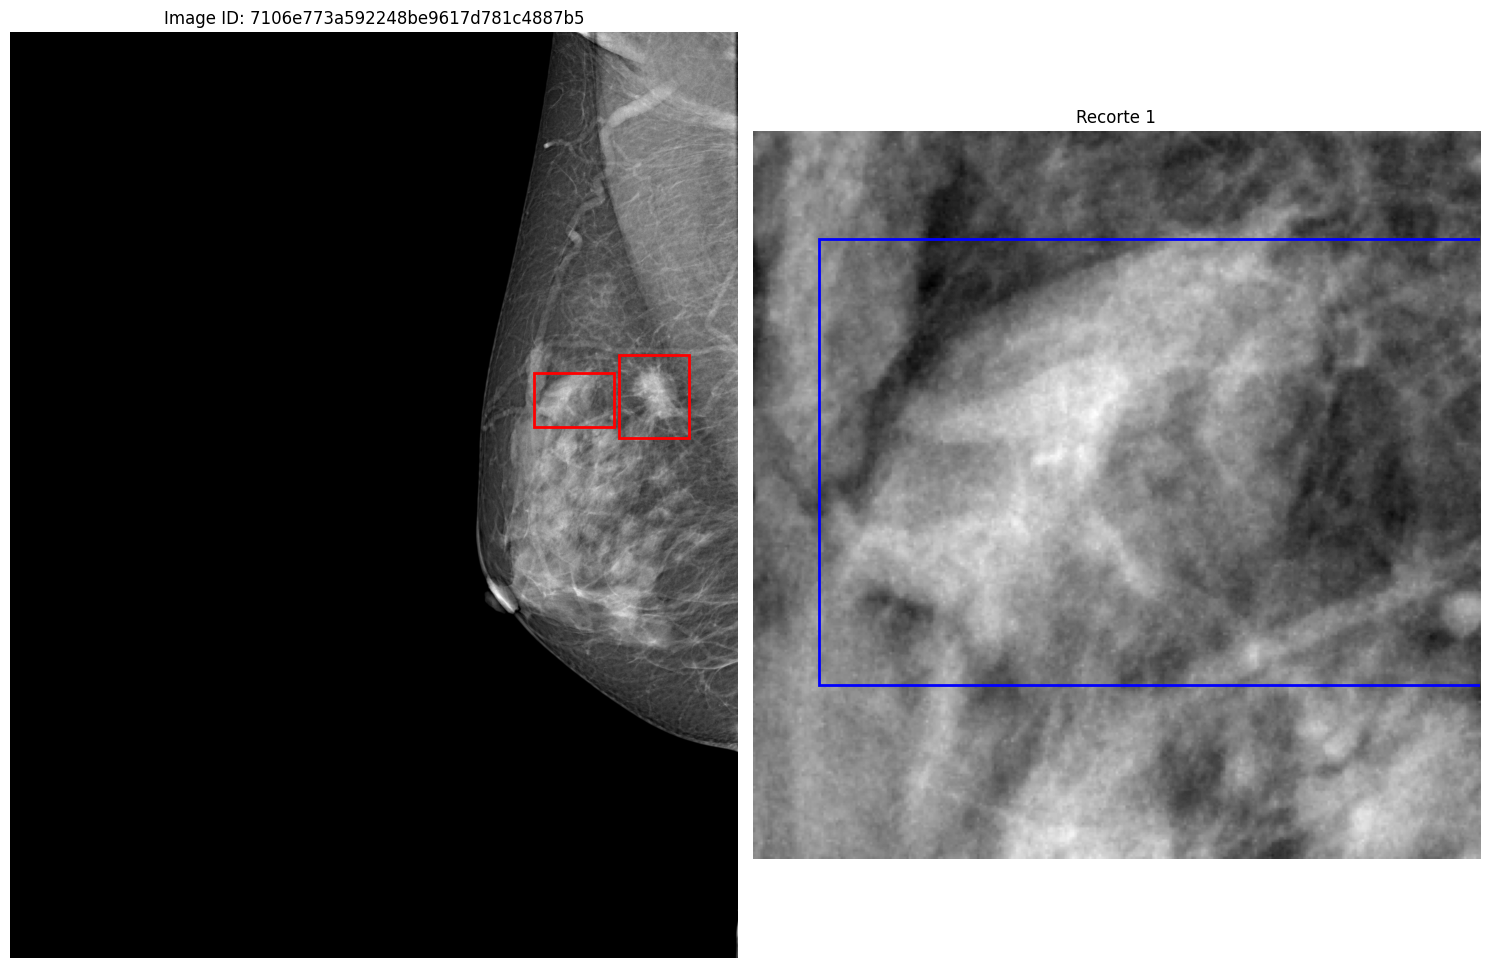

In [74]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
import ast

# Rutas al dataset DICOM y directorios de recortes
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_with_other'
roicrop1_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8'  # Ruta a ROICROP2

# Rutas a los CSV de anotaciones y metadatos
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/others_with_image_names.csv'
crop2_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/CROP8_AU.csv'  # Ruta a CROP2.csv
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar las anotaciones y el archivo de metadatos
findings = pd.read_csv(annotations_csv)
metadata = pd.read_csv(metadata_csv)
crops = pd.read_csv(crop2_csv)  # Cargar CROP2.csv

# Limpiar las categorías eliminando los caracteres adicionales
findings['finding_categories'] = findings['finding_categories'].apply(lambda x: x.strip("[]'"))

# Crear un DataFrame vacío para las nuevas coordenadas
ss1_rescaled = pd.DataFrame(columns=findings.columns)

# Lista de categorías para 'otros'
otros_categories = [
    'Focal Asymmetry',
    'Architectural Distortion',
    'Asymmetry',
    'Suspicious Lymph Node',
    'Skin Thickening',
    'Global Asymmetry',
    'Nipple Retraction',
    'Skin Retraction'
]

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    possible_extensions = ['.dicom', '.dcm', '']
    study_path = os.path.join(root_dir, study_id)
    if not os.path.isdir(study_path):
        print(f"Advertencia: El directorio del estudio '{study_id}' no existe en '{root_dir}'.")
        return None
    for ext in possible_extensions:
        dicom_filename = image_id + ext
        dicom_path = os.path.join(study_path, dicom_filename)
        if os.path.exists(dicom_path):
            return dicom_path
    print(f"Advertencia: No se encontró el archivo DICOM para image_id: {image_id} en '{study_path}'.")
    return None

# Función para mapear BIRADS a categorías
def map_birads_to_category(birads):
    if birads in ['BI-RADS 0', 'BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3']:
        return 'benigno'
    elif birads == 'BI-RADS 4':
        return 'sospechoso'
    elif birads in ['BI-RADS 5', 'BI-RADS 6']:
        return 'maligno'
    else:
        print(f"Advertencia: BIRADS desconocido '{birads}'. Asignando a 'benigno'.")
        return 'benigno'

# Función para aplicar el recorte basado en el centro de la ROI, con padding variable
def extract_roi(image_name, split, birads, finding_category, ss1_rescaled):
    # Obtener el image_id (parte antes del guión bajo "_")
    image_id = image_name.split('_')[0]
    study_id = image_name.split('_')[1] if '_' in image_name else ''  # Asumiendo que el study_id está después del primer '_'
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    
    if dicom_path is None:
        print(f"Error: No se encontró el archivo DICOM para la imagen {image_name}.")
        return ss1_rescaled

    # Leer la imagen DICOM
    try:
        dicom = pydicom.dcmread(dicom_path)
        original_image = dicom.pixel_array
    except Exception as e:
        print(f"Error al leer el archivo DICOM para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Aplicar VOI LUT
    try:
        img_windowed = apply_voi_lut(original_image, dicom, prefer_lut=True)
    except Exception as e:
        print(f"Error al aplicar VOI LUT para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Normalizar la imagen
    try:
        img_windowed = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
        img_windowed = img_windowed.astype(np.uint8)
    except Exception as e:
        print(f"Error al normalizar la imagen {image_name}: {e}")
        return ss1_rescaled

    # Extraer las coordenadas de la ROI
    try:
        x1 = int(findings.loc[findings['image_name'] == image_name, 'xmin'].values[0])
        y1 = int(findings.loc[findings['image_name'] == image_name, 'ymin'].values[0])
        x2 = int(findings.loc[findings['image_name'] == image_name, 'xmax'].values[0])
        y2 = int(findings.loc[findings['image_name'] == image_name, 'ymax'].values[0])
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return ss1_rescaled

    # Verificar que las coordenadas sean válidas
    if x1 >= x2 or y1 >= y2:
        print(f"Error: Coordenadas inválidas para la imagen {image_name}. x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}")
        return ss1_rescaled

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)

    # Calcular el centro de la ROI
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Determinar el tamaño de la ROI original
    width = x2 - x1
    height = y2 - y1

    # Agregar padding variable
    if width < MIN_SIZE or height < MIN_SIZE:
        padding_x = int(width * 0.2)
        padding_y = int(height * 0.2)
    else:
        padding_x = int(width * 0.05)
        padding_y = int(height * 0.05)

    # Establecer los nuevos límites de la imagen recortada
    x1_new = max(center_x - (MIN_SIZE // 2) - padding_x, 0)
    y1_new = max(center_y - (MIN_SIZE // 2) - padding_y, 0)
    x2_new = min(center_x + (MIN_SIZE // 2) + padding_x, img_windowed.shape[1])
    y2_new = min(center_y + (MIN_SIZE // 2) + padding_y, img_windowed.shape[0])

    # Recortar la imagen
    crop = img_windowed[y1_new:y2_new, x1_new:x2_new]

    # Verificar si el recorte no está vacío
    if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío o tiene dimensiones inválidas.")
        return ss1_rescaled

    # Redimensionar el recorte
    try:
        crop_resized = cv2.resize(crop, TARGET_SIZE)
    except cv2.error as e:
        print(f"Error al redimensionar el recorte para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Calcular las nuevas coordenadas reescaladas
    scale_x = TARGET_SIZE[0] / crop.shape[1]
    scale_y = TARGET_SIZE[1] / crop.shape[0]

    xmin_rescaled = int((x1 - x1_new) * scale_x)
    ymin_rescaled = int((y1 - y1_new) * scale_y)
    xmax_rescaled = int((x2 - x1_new) * scale_x)
    ymax_rescaled = int((y2 - y1_new) * scale_y)

    # Determinar el directorio base según el split
    if split.lower() in ['train', 'training']:
        base_dir = os.path.join(roicrop1_dir, 'training')
    elif split.lower() == 'test':
        base_dir = os.path.join(roicrop1_dir, 'test')
    else:
        print(f"Error: Split desconocido '{split}' para la imagen {image_name}.")
        return ss1_rescaled

    # Determinar la categoría de salida
    if finding_category == 'Mass':
        output_dir = os.path.join(base_dir, 'masas')
    elif finding_category == 'Suspicious Calcification':
        output_dir = os.path.join(base_dir, 'calcificaciones')
    elif finding_category in otros_categories:
        output_dir = os.path.join(base_dir, 'otros')
    else:
        print(f"Error: Categoría desconocida '{finding_category}' para la imagen {image_name}.")
        return ss1_rescaled

    # Mapear BIRADS a categoría
    birads_category = map_birads_to_category(birads)
    output_dir = os.path.join(output_dir, birads_category)

    # Asegurarse de que el directorio de salida existe
    os.makedirs(output_dir, exist_ok=True)

    # Guardar la imagen recortada
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    try:
        cv2.imwrite(output_path, crop_resized)
        print(f"Imagen ROI guardada en: {output_path}")
    except Exception as e:
        print(f"Error al guardar el recorte para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Guardar las coordenadas reescaladas
    try:
        new_row = findings.loc[findings['image_name'] == image_name].copy()
        new_row['xmin'] = xmin_rescaled
        new_row['ymin'] = ymin_rescaled
        new_row['xmax'] = xmax_rescaled
        new_row['ymax'] = ymax_rescaled
        ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)
    except Exception as e:
        print(f"Error al guardar las coordenadas reescaladas para la imagen {image_name}: {e}")
        return ss1_rescaled

    return ss1_rescaled

# Función para filtrar imágenes que tienen findings
def filter_images_with_findings():
    # Filtrar imágenes que no contengan "No Finding" en la categoría
    findings_with_finding = findings[findings['finding_categories'] != 'No Finding']
    return findings_with_finding

# Función para leer el archivo DICOM y aplicar VOI LUT (si está disponible)
def read_dicom_image(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    if dicom_path is None:
        return None, None
    try:
        dicom = pydicom.dcmread(dicom_path)
        # Aplicar VOI LUT con prefer_lut=True (priorizando LUT si está presente)
        image = apply_voi_lut(dicom.pixel_array, dicom)
        return dicom, image
    except Exception as e:
        print(f"Error al leer o procesar el archivo DICOM para {image_id}: {e}")
        return None, None

# Función para dibujar las cajas delimitadoras en la imagen
def draw_bounding_boxes(ax, image_id):
    # Obtener anotaciones para la imagen
    image_annotations = findings[findings['image_id'] == image_id]
    
    for idx, row in image_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['finding_birads']}")

# Función para asociar el image_id de findings con SOP Instance UID de metadata
def get_metadata_info(image_id):
    # Buscar la imagen correspondiente en el metadata usando el SOP Instance UID
    metadata_info = metadata[metadata['SOP Instance UID'] == image_id]
    if not metadata_info.empty:
        # Extraer la información de las columnas relevantes
        photometric_interpretation = metadata_info['Photometric Interpretation'].values[0]
        window_center_width_explanation = metadata_info['Window Center & Width Explanation'].values[0]
        return photometric_interpretation, window_center_width_explanation
    else:
        return None, None

# Función para encontrar y cargar los recortes asociados a una imagen
def get_recortes(image_name):
    recortes = []
    # Recorrer todas las subcarpetas de ROICROP2 (training y test)
    for split in ['training', 'test']:
        split_path = os.path.join(roicrop1_dir, split)
        for category in ['masas', 'calcificaciones', 'otros']:
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                continue
            for birads_category in ['benigno', 'maligno', 'sospechoso']:
                birads_path = os.path.join(category_path, birads_category) if category != 'otros' else category_path
                if not os.path.isdir(birads_path):
                    continue
                # Buscar archivos .png que correspondan al image_name
                for file in os.listdir(birads_path):
                    if file.startswith(image_name) and file.endswith('.png'):
                        recorte_path = os.path.join(birads_path, file)
                        recortes.append(recorte_path)
    return recortes

# Función para dibujar las cajas delimitadoras en los recortes PNG usando CROP2.csv
def draw_bounding_boxes_png(ax, crop_image_name):
    # Obtener anotaciones para el recorte desde CROP2.csv
    crop_annotations = crops[crops['image_name'] == crop_image_name]
    
    for idx, row in crop_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"Recorte ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['finding_birads']}")

# Función para mostrar una imagen DICOM aleatoria en alta resolución con ROI, recortes y metadatos
def show_random_dicom_with_roi_and_recortes_and_metadata():
    # Filtrar las filas que tienen findings
    findings_with_finding = filter_images_with_findings()
    
    if findings_with_finding.empty:
        print("No se encontraron imágenes con findings.")
        return
    
    # Seleccionar una fila aleatoria del dataset filtrado
    random_row = findings_with_finding.sample(n=1).iloc[0]
    
    # Obtener el image_id y study_id de la imagen seleccionada
    image_id = random_row['image_id']
    image_name = random_row['image_name']
    study_id = random_row['study_id']
    
    print(f"Mostrando imagen aleatoria con ID: {image_id}, Nombre de imagen: {image_name}, y Study ID: {study_id}")
    
    # Leer la imagen DICOM
    dicom, image = read_dicom_image(image_id, study_id)
    
    if dicom is None or image is None:
        print(f"No se pudo leer la imagen DICOM para {image_name}.")
        return
    
    # Manejar Photometric Interpretation si es MONOCHROME1 (invertir la imagen)
    photometric_interpretation = dicom.get('PhotometricInterpretation', 'UNKNOWN')
    if photometric_interpretation == 'MONOCHROME1':
        image = image.max() - image
        print(f"Imagen {image_name} tiene Photometric Interpretation: {photometric_interpretation} (invertida)")
    else:
        print(f"Imagen {image_name} tiene Photometric Interpretation: {photometric_interpretation}")
    
    # Normalizar la imagen para mostrarla correctamente
    try:
        image = (image - image.min()) / (image.max() - image.min()) * 255
        image = image.astype('uint8')
    except Exception as e:
        print(f"Error al normalizar la imagen {image_name}: {e}")
        return
    
    # Obtener información de metadatos del CSV 'metadata.csv'
    photometric_interpretation_csv, window_center_width_explanation = get_metadata_info(image_id)
    
    if photometric_interpretation_csv and window_center_width_explanation:
        print(f"\nMetadatos asociados a la imagen:")
        print(f"Photometric Interpretation (desde CSV): {photometric_interpretation_csv}")
        print(f"Window Center & Width Explanation: {window_center_width_explanation}")
    else:
        print("\nNo se encontraron metadatos para esta imagen.")
    
    # Crear una figura con subplots: 1 para la imagen DICOM y varios para los recortes
    recortes_paths = get_recortes(image_name)
    num_recortes = len(recortes_paths)
    
    if num_recortes == 0:
        print(f"No se encontraron recortes para la imagen {image_name} en ROICROP2.")
    
    # Definir el tamaño de la figura
    fig_width = 12 + 3 * num_recortes  # Ajustar según la cantidad de recortes
    fig_height = 12
    fig, axes = plt.subplots(1, max(2, num_recortes + 1), figsize=(fig_width, fig_height))
    
    # Si solo hay un subplot, convertirlo en una lista para iterar
    if num_recortes == 0:
        axes = [axes]
    
    # Mostrar la imagen DICOM
    ax_main = axes[0]
    ax_main.imshow(image, cmap='gray')
    draw_bounding_boxes(ax_main, image_id)
    ax_main.set_title(f"Image ID: {image_id}")
    ax_main.axis('off')  # Ocultar los ejes para mejor visualización
    
    # Mostrar los recortes asociados
    for idx, recorte_path in enumerate(recortes_paths):
        try:
            recorte = cv2.imread(recorte_path, cv2.IMREAD_GRAYSCALE)
            if recorte is None:
                print(f"Error: No se pudo leer el recorte en {recorte_path}.")
                continue
            # Normalizar el recorte
            recorte = (recorte - recorte.min()) / (recorte.max() - recorte.min()) * 255
            recorte = recorte.astype('uint8')
            
            ax = axes[idx + 1]
            ax.imshow(recorte, cmap='gray')
            ax.set_title(f"Recorte {idx + 1}")
            ax.axis('off')
            
            # Obtener el nombre del recorte sin extensión
            recorte_name = os.path.splitext(os.path.basename(recorte_path))[0]
            
            # Dibujar bounding boxes en el recorte utilizando CROP2.csv
            draw_bounding_boxes_png(ax, recorte_name)
        except Exception as e:
            print(f"Error al procesar el recorte {recorte_path}: {e}")
            continue
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función para mostrar una imagen DICOM aleatoria con sus recortes y metadatos
show_random_dicom_with_roi_and_recortes_and_metadata()


### Realizamos un conteo de los recortes aumentados

In [31]:
import os

def count_png_images(output_root):
    """
    Cuenta la cantidad de imágenes .png en cada subdirectorio de ROICROP8.

    Parámetros:
    - output_root (str): Ruta al directorio ROICROP8.

    Retorna:
    - None: Imprime los resultados en la consola.
    """
    counts = {}
    total_images = 0

    # Definir splits y categorías
    splits = ['training', 'test']
    categories = ['masas', 'calcificaciones', 'otros']
    birads_categories = ['benigno', 'maligno', 'sospechoso']

    for split in splits:
        split_path = os.path.join(output_root, split)
        if not os.path.isdir(split_path):
            print(f"Advertencia: El directorio split '{split}' no existe en '{output_root}'.")
            continue
        
        counts[split] = {}
        for category in categories:
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                print(f"Advertencia: El directorio categoría '{category}' no existe en '{category_path}'.")
                continue
            
            counts[split][category] = {}
            for birads in birads_categories:
                birads_path = os.path.join(category_path, birads)
                if not os.path.isdir(birads_path):
                    print(f"Advertencia: El directorio BIRADS '{birads}' no existe en '{birads_path}'.")
                    continue
                
                # Contar archivos .png (ignorando mayúsculas/minúsculas)
                png_files = [f for f in os.listdir(birads_path) if f.lower().endswith('.png')]
                count = len(png_files)
                counts[split][category][birads] = count
                total_images += count

    # Imprimir los resultados
    print("\nCantidad de imágenes .png por categoría y subcategoría:")
    for split, categories_data in counts.items():
        print(f"\nSplit: {split.capitalize()}")
        for category, birads_data in categories_data.items():
            print(f"  Categoría: {category.capitalize()}")
            for birads, count in birads_data.items():
                print(f"    {birads.capitalize()}: {count} imágenes")
    
    print(f"\nTotal de imágenes .png en '{output_root}': {total_images}")

# Ruta al directorio ROICROP8
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8'

# Ejecutar la función de conteo
count_png_images(output_root)



Cantidad de imágenes .png por categoría y subcategoría:

Split: Training
  Categoría: Masas
    Benigno: 443 imágenes
    Maligno: 443 imágenes
    Sospechoso: 443 imágenes
  Categoría: Calcificaciones
    Benigno: 224 imágenes
    Maligno: 224 imágenes
    Sospechoso: 224 imágenes
  Categoría: Otros
    Benigno: 215 imágenes
    Maligno: 215 imágenes
    Sospechoso: 215 imágenes

Split: Test
  Categoría: Masas
    Benigno: 123 imágenes
    Maligno: 14 imágenes
    Sospechoso: 81 imágenes
  Categoría: Calcificaciones
    Benigno: 11 imágenes
    Maligno: 20 imágenes
    Sospechoso: 60 imágenes
  Categoría: Otros
    Benigno: 49 imágenes
    Maligno: 14 imágenes
    Sospechoso: 47 imágenes

Total de imágenes .png en '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/augmented_images/ROI_CROP8': 3065


El método de data augmentation implementado en este script utiliza la librería Albumentations para aplicar una serie de transformaciones geométricas y fotométricas a las imágenes originales de DICOM, con el objetivo de balancear las clases en el conjunto de entrenamiento. Primero, el script lee y procesa cada imagen DICOM, aplicando ajustes como rotaciones aleatorias, flips horizontales y verticales, traslaciones, escalados, cambios de brillo y contraste, y desenfoques gaussianos. Estas transformaciones se realizan manteniendo y ajustando las bounding boxes correspondientes a las Regiones de Interés (ROIs) para asegurar que las anotaciones sigan siendo precisas después de la modificación de la imagen. El proceso de augmentación se repite iterativamente hasta alcanzar el número deseado de imágenes por categoría y subcategoría (benigno, maligno, sospechoso), generando nuevas imágenes con nombres únicos que comienzan con "aug_". Finalmente, las nuevas imágenes aumentadas se guardan en las carpetas correspondientes y sus nuevas coordenadas se actualizan en un archivo CSV, garantizando así un dataset balanceado que mejora la capacidad del modelo de deep learning para generalizar y manejar clases desbalanceadas de manera más efectiva.